<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [1]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt
import matplotlib.pylab

import pandas as pd
import numpy as np
import datetime

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.simplefilter(action="ignore")

In [ ]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

## Задание 1 (2 балла). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекоммендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



Оба временных ряда были взяты с Kaggle:

Дневные данные представляют собой продажи, совершаемые в крупной сети Эквадорских розничных магазинов по продаже продуктов питания. 

Ссылка: https://www.kaggle.com/c/favorita-grocery-sales-forecasting

Месячные данные представляют собой выбросы СО2 от производства электроэнергии. В этой работе рассматриваются выбросы углекислого газа при производстве электроэнергии от природного газа.

Ссылка: https://www.kaggle.com/txtrouble/carbon-emissions

P.S.: Оба датасета скачены с Kaggle и загружены на диск, а уже в данном ноутбуке полностью предобработаны. 

In [ ]:
# скачаем данные

!wget https://www.dropbox.com/s/z3ub7iwrgid2zfs/daily.zip
! unzip -q daily.zip 

!wget https://www.dropbox.com/s/e2xqswi5am514p4/monthly1.zip
! unzip -q monthly1.zip 

In [7]:
# Предобработка месячных данных
dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
df = pd.read_csv("MER_T12_06.csv", parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse) 
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]
ts['Value'] = pd.to_numeric(ts['Value'] , errors='coerce')
ts1 = ts[ts['Description'] == 'Natural Gas Electric Power Sector CO2 Emissions']
ts1 = ts1.asfreq('M', method='bfill')
ts1 = ts1.loc['1987':]
ts1 = pd.Series(ts1.Value)

In [12]:
# Предобработка дневных данных
ts2 = pd.read_csv('daily/transactions.csv')
ts2.date = ts2.date.apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d')) 
transac = ts2.groupby('date')['transactions'].sum()
ts2 = pd.Series(transac)
ts2 = ts2.asfreq('d', method='bfill')
ts2 = ts2.loc['2014-03-01':]

In [13]:
# сделаем разбиение на train/test для месячных данных

test_size = int(0.8 * len(ts1)) 

train_df_ts1 = ts1.iloc[:test_size]
test_df_ts1  = ts1.iloc[test_size:]

In [14]:
# сделаем разбиение на train/test для дневных данных

test_size_daily = int(0.8 * len(ts2)) 

train_df_ts2 = ts2.iloc[:test_size_daily]
test_df_ts2  = ts2.iloc[test_size_daily:]

## Задание 2. Анализ временных рядов (1 балла).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики автокорреляционных функций для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

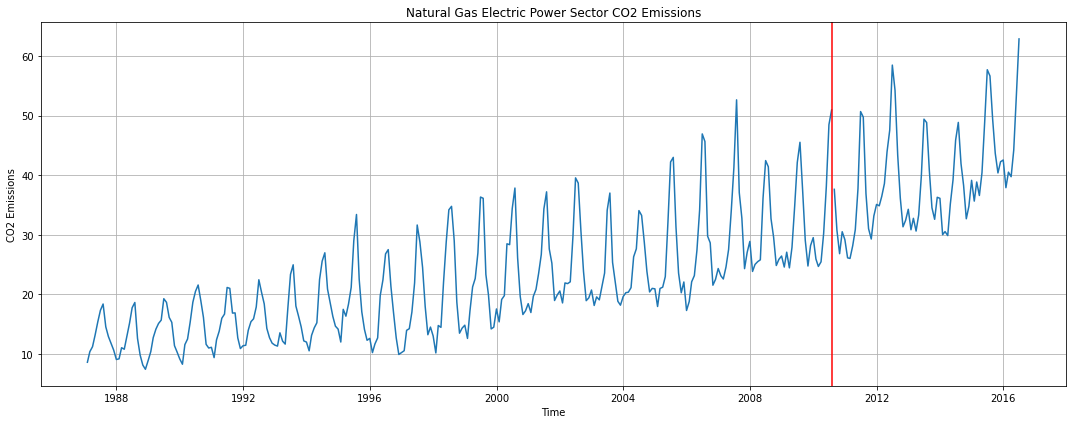

In [15]:
# Отрисуем временной ряд для месячных данных
plt.figure(figsize=(15, 6))
plt.plot(train_df_ts1.index, train_df_ts1, color='#1f77b4')
plt.plot(test_df_ts1.index, test_df_ts1, color='#1f77b4')
plt.axvline(x=train_df_ts1.index[-1], color='red')
plt.title('Natural Gas Electric Power Sector CO2 Emissions')
plt.xlabel('Time')
plt.ylabel('CO2 Emissions')
plt.grid(b=1)
plt.tight_layout()
plt.show()

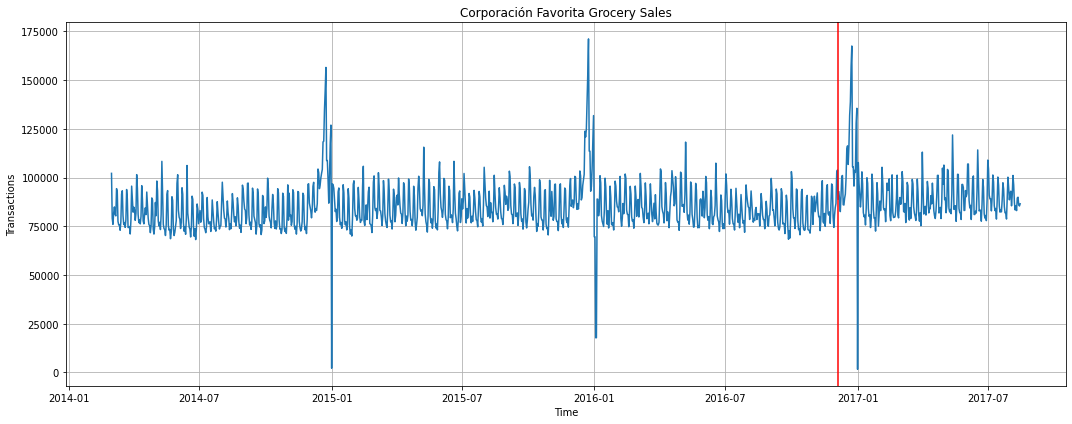

In [16]:
# Отрисуем временной ряд для дневных данных
plt.figure(figsize=(15, 6))
plt.plot(train_df_ts2.index, train_df_ts2, color='#1f77b4')
plt.plot(test_df_ts2.index, test_df_ts2, color='#1f77b4')
plt.axvline(x=train_df_ts2.index[-1], color='red')
plt.title('Corporación Favorita Grocery Sales')
plt.xlabel('Time')
plt.ylabel('Transactions')
plt.grid(b=1)
plt.tight_layout()
plt.show()

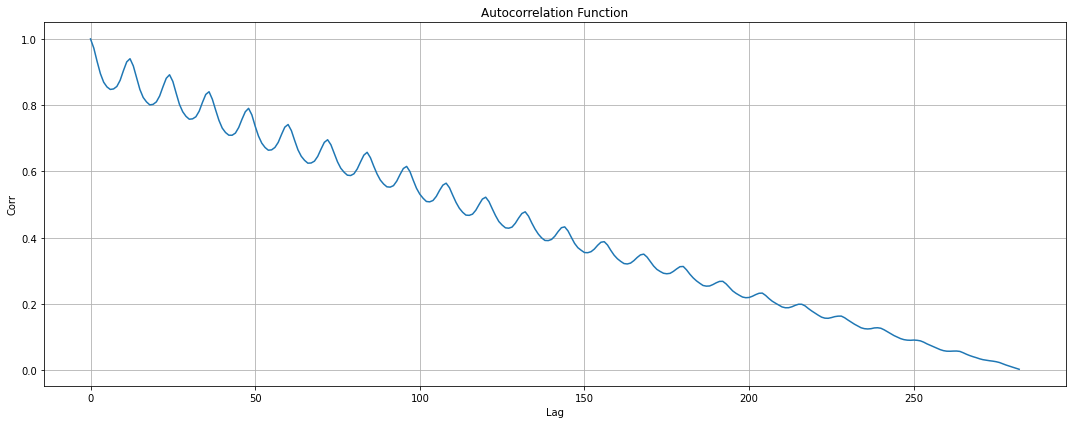

In [17]:
# посчитайте и нарисуйте график автокорреляционной функции
# hint, используйте для этого np.correlate(..., mode='full')
corrs = np.correlate(train_df_ts1, train_df_ts1, mode='full')
z = corrs[corrs.size // 2:]

plt.figure(figsize=(15, 6))
plt.plot(z / float(z.max()))
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Corr')
plt.grid(b=1)
plt.tight_layout()
plt.show()

Вывод по автокорреляционной функции: сезонная составляющая довольно сильно проявляется каждые 12 точек, а поскольку данные месячные, то мы можем точно сказать, что текущий январь зависит от предыдущего. Для процессов выбросов СО2 это логично, поскольку влияют отопительные сезоны, с/х производство и тд.

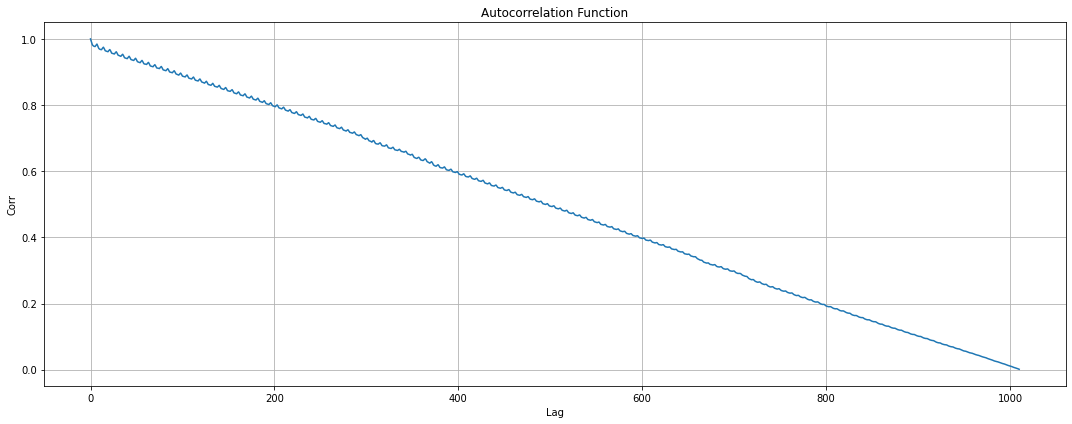

In [18]:
corrs = np.correlate(train_df_ts2, train_df_ts2, mode='full')
z = corrs[corrs.size // 2:]

plt.figure(figsize=(15, 6))
plt.plot(z / float(z.max()))
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Corr')
plt.grid(b=1)
plt.tight_layout()
plt.show()

Вывод по автокорреляционной функции: сезонность есть, как можно видеть из графика автокорреляционной функции, причём имеет место как недельная сезонность, так и месячная. Это логично, учитывая, что количество транзакций может зависиеть от выходного дня (люди совершают покупки) и от разных месяцев (люди закупаются перед праздниками).

P.S. Для того, чтобы разглядеть эти наблюдения, я строил отдельно транзакции для 2017 года, там более крупная картинка!

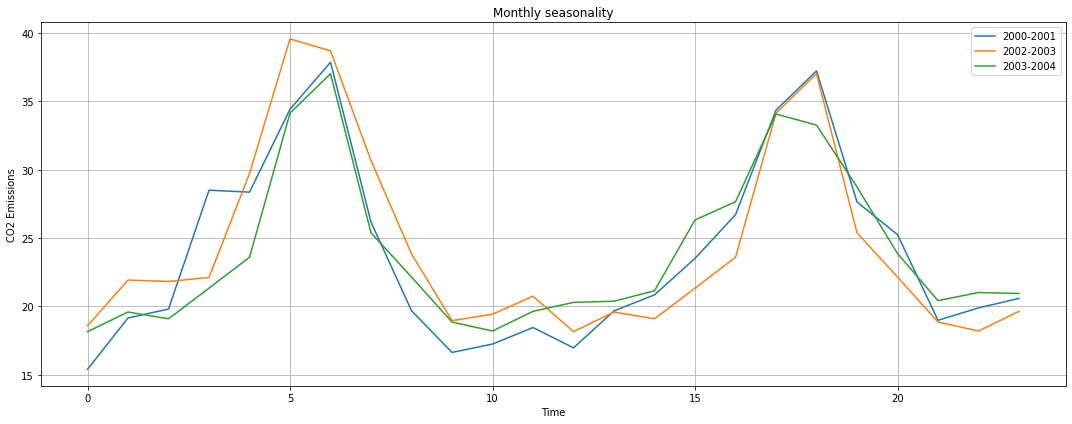

In [19]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными
part1 = ts1.loc['2000':'2001']
part2 = ts1.loc['2002':'2003']
part3 = ts1.loc['2003':'2004']

plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(part1)), part1, label='2000-2001')
plt.plot(np.arange(len(part2)), part2, label='2002-2003')
plt.plot(np.arange(len(part3)), part3, label='2003-2004')
plt.title('Monthly seasonality')
plt.xlabel('Time')
plt.ylabel('CO2 Emissions')
plt.grid(b=1)
plt.tight_layout()
plt.legend()
plt.plot();

Комментарий: видно, что имеется явновыраженная сезонность, соответствующая месячной частоте.

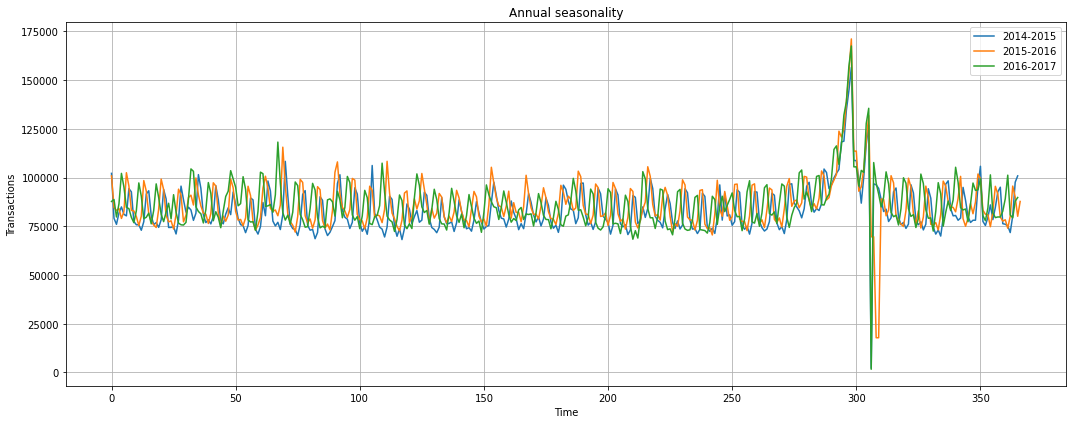

In [20]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными
part1 = ts2.loc['2014-03-01':'2015-03-01']
part2 = ts2.loc['2015-03-01':'2016-03-01']
part3 = ts2.loc['2016-03-01':'2017-03-01']

plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(part1)), part1, label='2014-2015')
plt.plot(np.arange(len(part2)), part2, label='2015-2016')
plt.plot(np.arange(len(part3)), part3, label='2016-2017')
plt.title('Annual seasonality')
plt.xlabel('Time')
plt.ylabel('Transactions')
plt.grid(b=1)
plt.tight_layout()
plt.legend()
plt.plot();

Комментарий: как видим выше, гипотеза о наличии недельной и годовой сезонности подтверждается для трёх рассматриваемых годов, из которых состоит датасет.

## Задание 3. Предсказание месячного временного ряда (4.5 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.


In [21]:
def plot_of_series(y_train, y_test, y_pred):

    plt.figure(figsize=(15, 6))
    plt.plot(train_df_ts1.index, y_train, label='Train', color='#1f77b4')
    plt.plot(test_df_ts1.index, y_test, label='Test', color='#1f77b4')
    plt.plot(test_df_ts1.index, y_pred, label='Pred', color='#9467bd')
    plt.axvline(x=train_df_ts1.index[-1], color='red')
    plt.xlabel('Time')
    plt.ylabel('CO2 Emissions')
    plt.grid(b=1)
    plt.tight_layout()
    plt.legend()
    plt.show()  

### NaiveForecaster из sktime (0.5 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

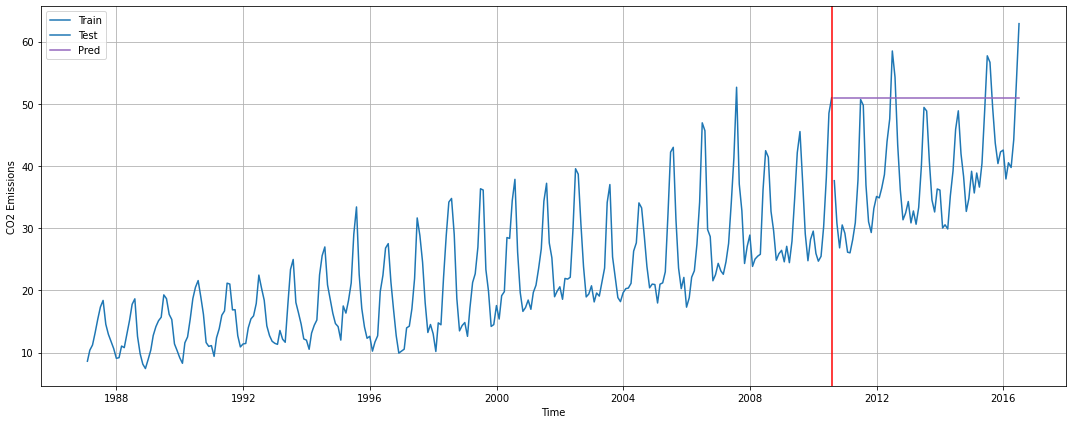

MAE: 13.064014084507047


In [22]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_absolute_error

# ваш код обучения моделей здесь
forecaster = NaiveForecaster(strategy='last')
fh = ForecastingHorizon(test_df_ts1.index, is_relative=False)
forecaster.fit(train_df_ts1)
y_pred = forecaster.predict(fh)

plot_of_series(train_df_ts1, test_df_ts1, y_pred)
print('MAE:', mean_absolute_error(test_df_ts1, y_pred))

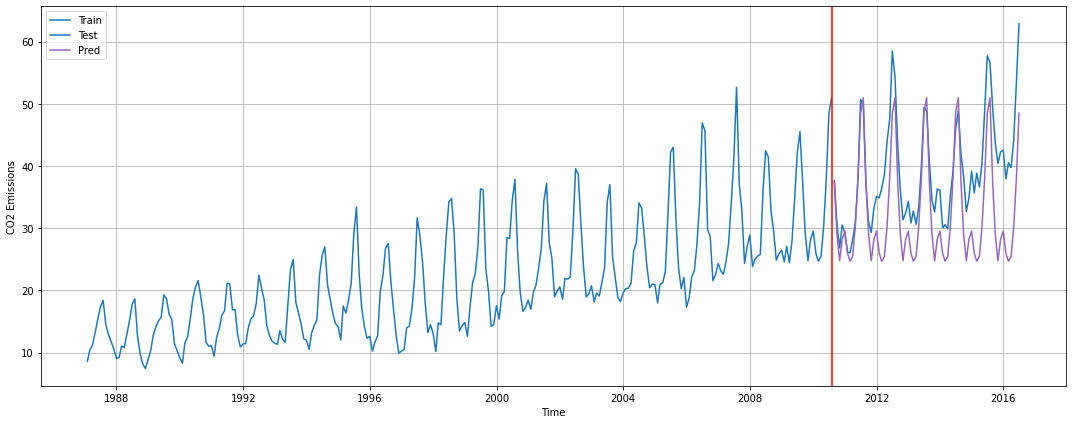

MAE: 6.736661971830985


In [23]:
forecaster = NaiveForecaster(strategy='last', sp=12)
forecaster.fit(train_df_ts1)
y_pred = forecaster.predict(fh)

plot_of_series(train_df_ts1, test_df_ts1, y_pred)
print('MAE:', mean_absolute_error(test_df_ts1, y_pred))

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

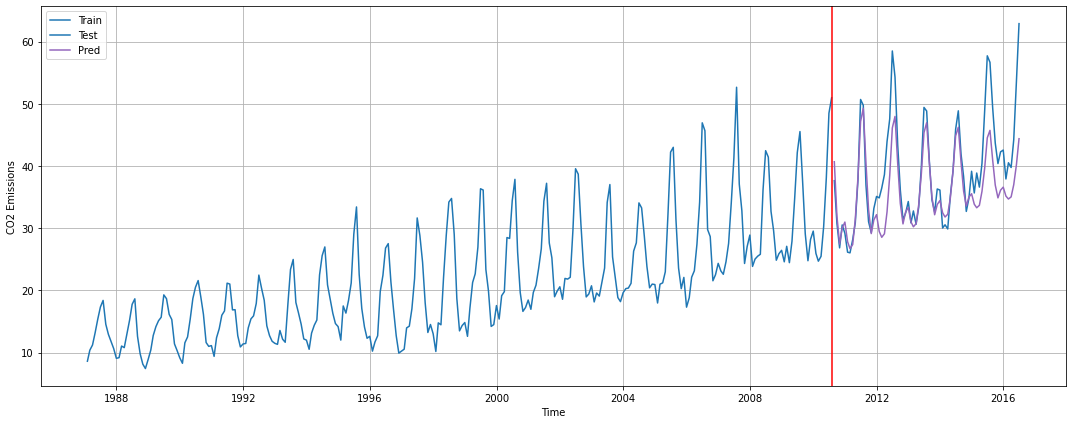

MAE: 3.6912178824930644


In [24]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

# ваш код обучения моделей здесь
forecaster = ARIMA(
    order = (1, 1, 1),
    seasonal_order=(1, 0, 0, 12)
)
forecaster.fit(train_df_ts1)
y_pred = forecaster.predict(fh)
plot_of_series(train_df_ts1, test_df_ts1, y_pred)
print('MAE:', mean_absolute_error(test_df_ts1, y_pred))

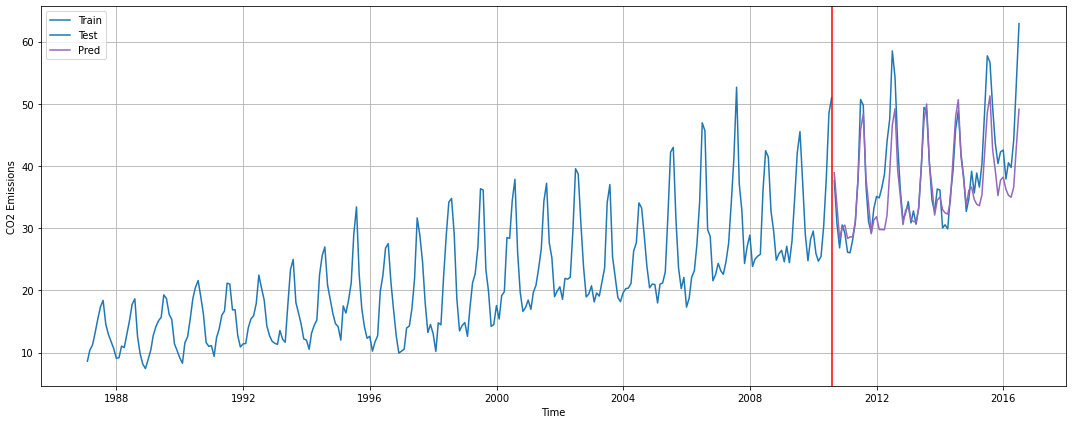

MAE: 3.226266705429142


In [25]:
forecaster = AutoARIMA(sp=12, d=1, max_p=3, max_q=3, suppress_warnings=True)
forecaster.fit(train_df_ts1)
y_pred = forecaster.predict(fh)
plot_of_series(train_df_ts1, test_df_ts1, y_pred)
print('MAE:', mean_absolute_error(test_df_ts1, y_pred))

### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [26]:
from orbit.models.lgt import LGTFull
from orbit.models.dlt import DLTFull
from orbit.diagnostics.plot import plot_predicted_data

df_train_ts1 = pd.DataFrame({'Date': train_df_ts1.index, 'Value': train_df_ts1})
df_test_ts1 = pd.DataFrame({'Date': test_df_ts1.index, 'Value': test_df_ts1})

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0a449c7523386cce384e92a998e71c8 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


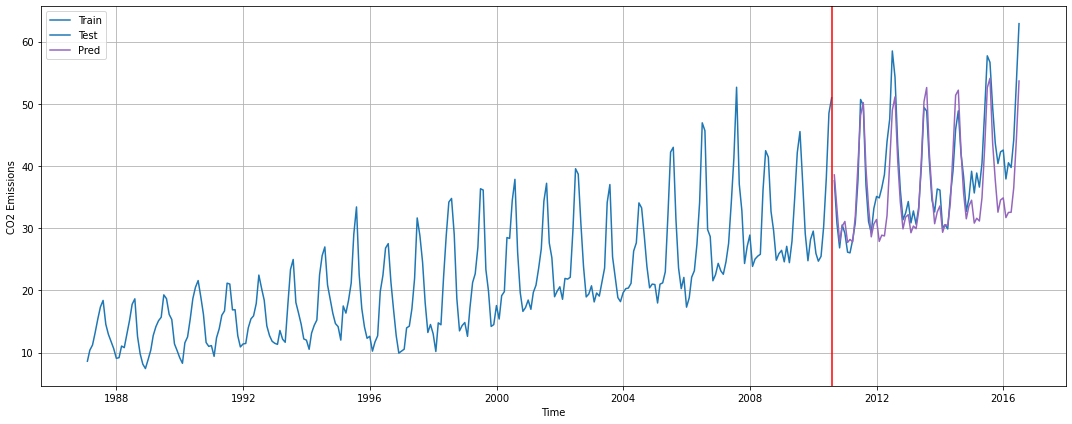

MAE: 3.643780546034329


In [27]:
# ваш код обучения моделей здесь
dlt = DLTFull(
    response_col='Value', 
    date_col='Date',
    seasonality=12
)

dlt.fit(df=df_train_ts1)
predicted_df = dlt.predict(df=df_test_ts1)
plot_of_series(df_train_ts1.Value, df_test_ts1.Value, predicted_df['prediction'])
print('MAE:', mean_absolute_error(df_test_ts1.Value, predicted_df['prediction']))

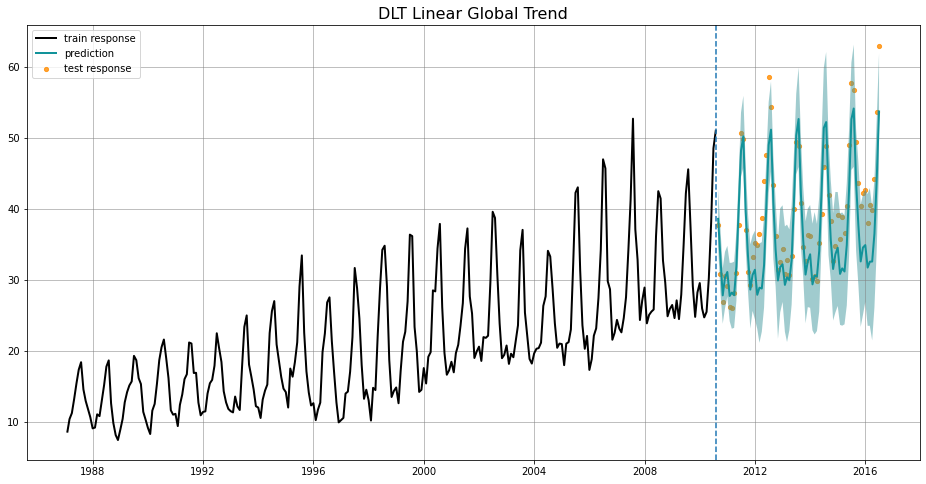

In [28]:
# Прогноз с доверительным интервалом для DLT
_ = plot_predicted_data(
    training_actual_df=df_train_ts1, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=df_test_ts1, insample_line=True, title='DLT Linear Global Trend'
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2af9ff5e07f97061bbe4badb0f8a2e36 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


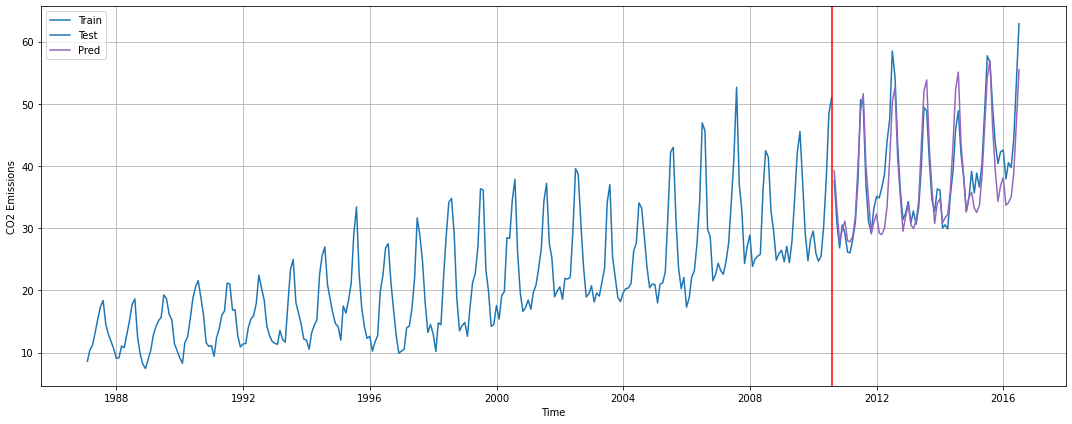

MAE: 3.0532659279335257


In [29]:
lgt = LGTFull(
    response_col='Value', 
    date_col='Date',
    seasonality=12,
    seed=2
)

lgt.fit(df=df_train_ts1)
predicted_df = lgt.predict(df=df_test_ts1)
plot_of_series(df_train_ts1.Value, df_test_ts1.Value, predicted_df['prediction'])
print('MAE:', mean_absolute_error(df_test_ts1.Value, predicted_df['prediction']))

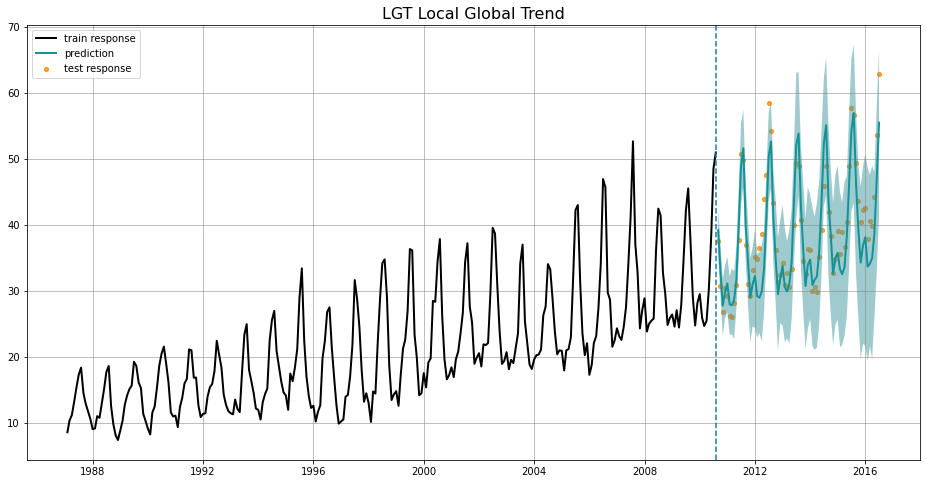

In [30]:
# Прогноз с доверительным интервалом для LGT
_ = plot_predicted_data(
    training_actual_df=df_train_ts1, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=df_test_ts1, insample_line=True,  title='LGT Local Global Trend'
)

Комментарий: DLT проиграл LGT в качестве прогноза и этот факт имеет логичную идейную интерпретацию: у DLT предполагается Damped Trend, однако прямого затухания в данных не наблюдается на текущий момент.

### ETS (2 балла).

Обучите из библиотеки `sklearn` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [31]:
train_ets = train_df_ts1.copy()
train_ets.index = pd.PeriodIndex(train_ets.index)
test_ets = test_df_ts1.copy()
test_ets.index = pd.PeriodIndex(test_ets.index)

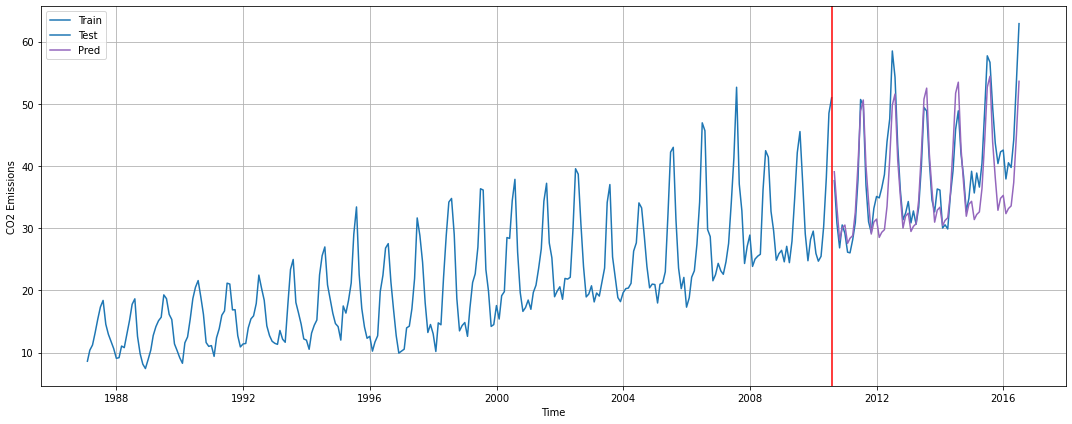

MAE: 3.4572551290067537


In [32]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

fh = ForecastingHorizon(test_ets.index, is_relative=False)
forecaster = ExponentialSmoothing(trend='add', seasonal='add', sp=12)
forecaster.fit(train_ets)
y_pred = forecaster.predict(fh)
plot_of_series(train_ets, test_df_ts1, y_pred)
print('MAE:', mean_absolute_error(test_df_ts1, y_pred))

Комментарий: обычная ETS модель хорошо ловит тренд и сезонность, однако в отличии от орбитовских моделей (DLT и LGT), которые по сути состоят в одном классе с ETS, но имеют более продвинутые функции и баесовскую регуляризацию, не смогла получить качество лучше LGT.

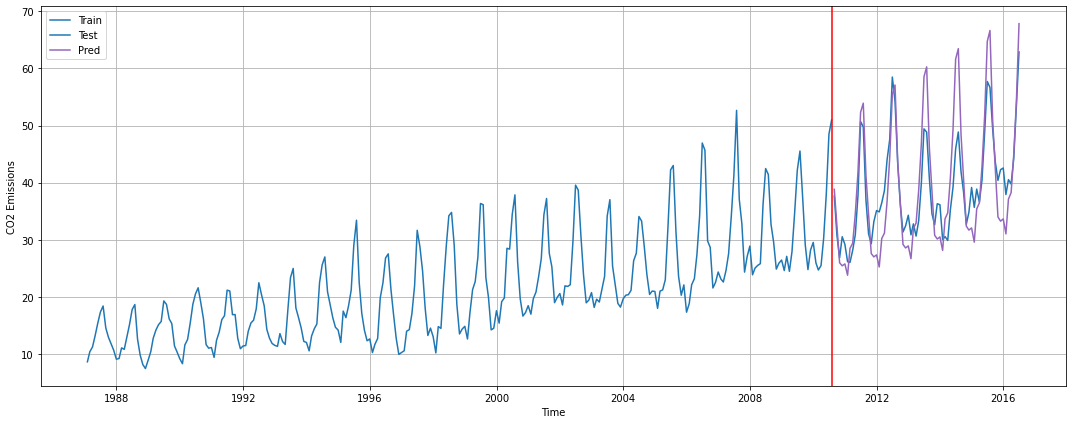

MAE: 4.539673068996474


In [33]:
forecaster = AutoETS(auto=True, sp=12, maxiter=10000)
forecaster.fit(train_ets)
y_pred = forecaster.predict(fh)
plot_of_series(train_ets, test_df_ts1, y_pred)
print('MAE:', mean_absolute_error(test_df_ts1, y_pred))

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

## Задание 4. Предсказание дневного временного ряда (2.5 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (0.5 балла).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [34]:
def plot_of_series_daily(y_train, y_test, y_pred):

    plt.figure(figsize=(15, 6))
    plt.plot(train_df_ts2.index, y_train, label='Train', color='#1f77b4')
    plt.plot(test_df_ts2.index, y_test, label='Test', color='#1f77b4')
    plt.plot(test_df_ts2.index, y_pred, label='Pred', color='#9467bd')
    plt.axvline(x=train_df_ts2.index[-1], color='red')
    plt.xlabel('Time')
    plt.ylabel('Transactions')
    plt.legend()
    plt.grid(b=1)
    plt.tight_layout()
    plt.show()  

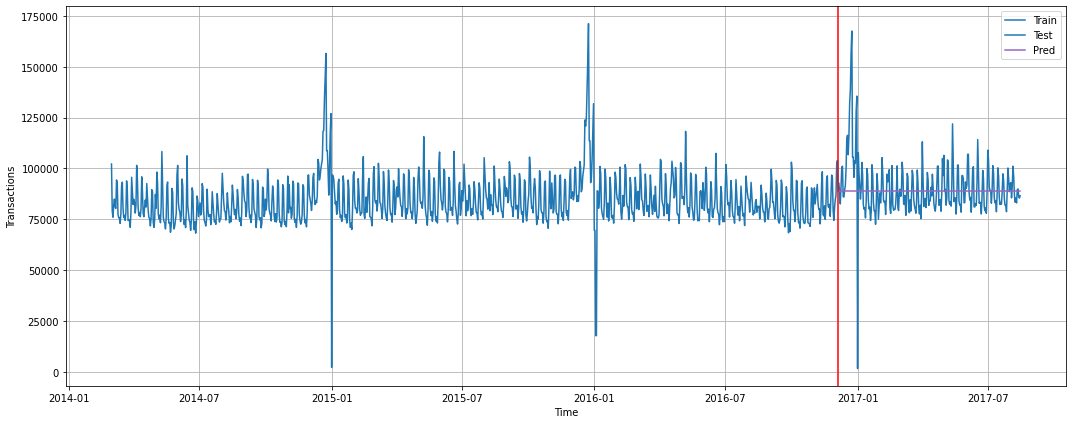

MAE: 8952.288537549408


In [35]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_absolute_error

# ваш код обучения моделей здесь
forecaster = NaiveForecaster(strategy='last')
fh = ForecastingHorizon(test_df_ts2.index, is_relative=False)
forecaster.fit(train_df_ts2)
y_pred = forecaster.predict(fh)

plot_of_series_daily(train_df_ts2, test_df_ts2, y_pred)
print('MAE:', mean_absolute_error(test_df_ts2, y_pred))

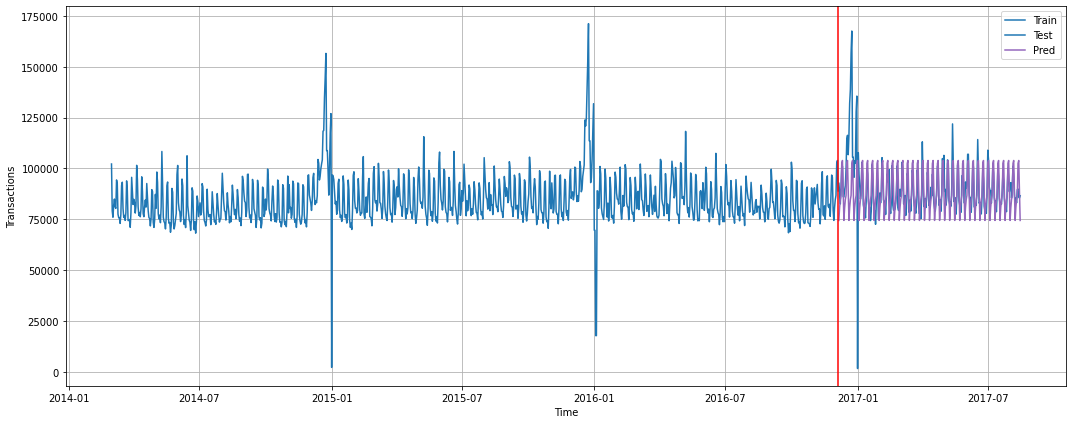

MAE: 7758.770750988142


In [36]:
forecaster = NaiveForecaster(strategy='last', sp=7)
forecaster.fit(train_df_ts2)
y_pred = forecaster.predict(fh)

plot_of_series_daily(train_df_ts2, test_df_ts2, y_pred)
print('MAE:', mean_absolute_error(test_df_ts2, y_pred))

### KTR из orbit (1 балл).



In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_train_ts2 = pd.DataFrame({'Date': train_df_ts2.index, 'transactions': train_df_ts2})
df_test_ts2 = pd.DataFrame({'Date': test_df_ts2.index, 'transactions': test_df_ts2})

train_ktr = df_train_ts2.copy()
test_ktr = df_test_ts2.copy()

train_ktr.transactions = scaler.fit_transform(train_ktr.transactions.values.reshape(-1, 1))
test_ktr.transactions = scaler.transform(test_ktr.transactions.values.reshape(-1, 1))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_54eae5ecf2d426f33baa7b746b329122 NOW.


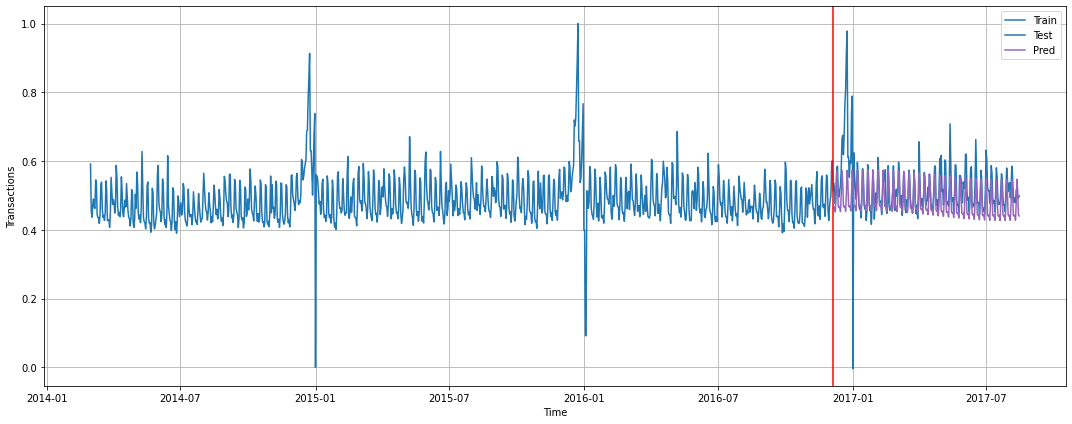

MAE: 0.045747166847380435


In [38]:
from orbit.models.ktrlite import KTRLiteMAP

# ваш код обучения моделей здесь
ktrlite = KTRLiteMAP(
    response_col='transactions', 
    date_col='Date',
    seasonality=[7, 365],
    seasonality_fs_order=[2, 1],
    level_knot_scale=.001,
    span_level=.025,
    span_coefficients=.3
)

ktrlite.fit(df=train_ktr)
predicted_df = ktrlite.predict(df=test_ktr)
plot_of_series_daily(train_ktr.transactions, test_ktr.transactions, predicted_df['prediction'])
print('MAE:', mean_absolute_error(test_ktr.transactions, predicted_df['prediction']))

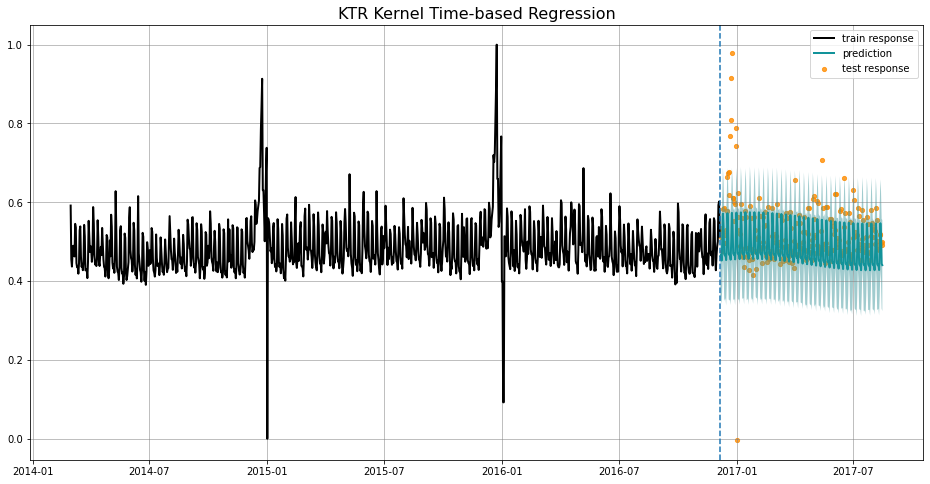

In [39]:
_ = plot_predicted_data(
    training_actual_df=train_ktr, predicted_df=predicted_df,
    date_col=ktrlite.date_col, actual_col=ktrlite.response_col,
    test_actual_df=test_ktr, insample_line=True, title='KTR Kernel Time-based Regression'
)

### Phophet (1 балл).



In [40]:
df_holidays_events = pd.read_csv('daily/holidays_events.csv')
holidays = df_holidays_events[df_holidays_events['transferred'] == False][['description', 'date']]
holidays.columns = ['holiday', 'ds']

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


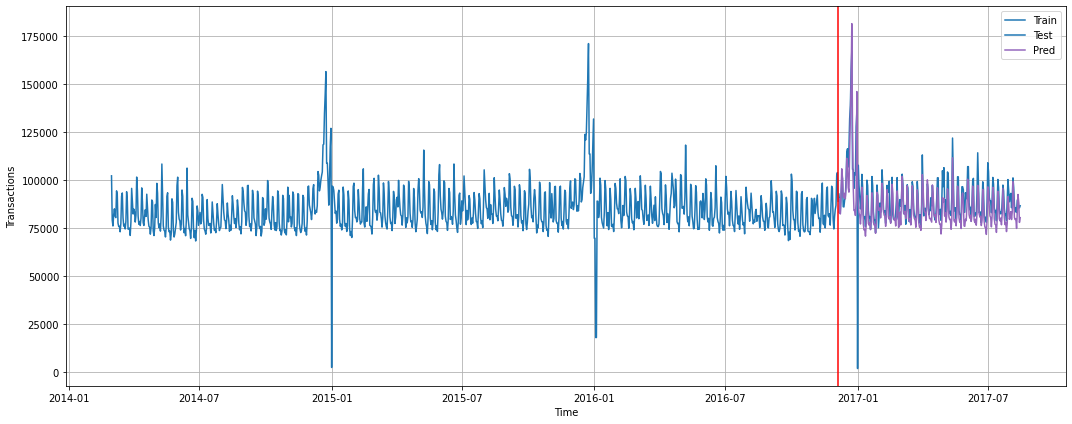

MAE: 6212.906719382497


In [41]:
from prophet import Prophet

train_df_prophet = df_train_ts2[['Date', 'transactions']]
train_df_prophet.columns = ['ds', 'y']

future = df_test_ts2[['Date']]
future.columns = ['ds']

# ваш код обучения моделей здесь
m = Prophet(interval_width=0.9, changepoint_prior_scale=0.25, holidays=holidays)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='weekly', period=7, fourier_order=5)
m.fit(train_df_prophet)

forecast = m.predict(future)
plot_of_series_daily(df_train_ts2.transactions, df_test_ts2.transactions, forecast['yhat'])
print('MAE:', mean_absolute_error(df_test_ts2.transactions, forecast['yhat']))

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

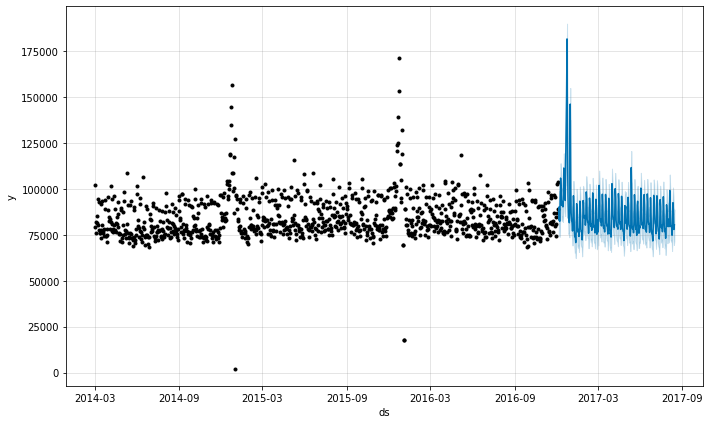

In [42]:
# С доверительный интервалом
fig1 = m.plot(forecast)

## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытай свою модель для месячного ряда в STAN.

Сравните качество прогнозов с наивной сезонной на тестовой выборке с помощью MAE. 



Теоретическое описание модели BARNAUL на вероятностном языке программирования STAN

Случайная ошибка:
$$
u_t \sim N(0; \sigma^2)
$$

Наклон тренда (ежемесячная скорость роста):
$$
b_t = b_{t-1} + \beta u_t
$$

Сезонная прибавка:
$$
s_t = s_{t-12} + \gamma u_t
$$

Десезонированный показатель:
$$
\ell_t = \ell_{t-1} + b_{t-1} + \alpha u_t
$$
Наблюдаемый показатель:
$$
y_t = \ell_{t-1} + b_{t-1} + s_{t-12} + u_t
$$
* Выражаем $u_t$ из последнего уравнения и подставляем в остальные. 

$$
u_t = y_t - \ell_{t-1} - b_{t-1} - s_{t-12} 
$$

* Записываем уравнения на $b_t$, $s_t$ и $\ell_t$ в виде средневзвешенного двух значений: "прошлого" и "нового". 

$$
b_t = (1- \beta) b_{t-1} + \beta (y_t - \ell_{t-1} - s_{t-12})
$$

$$
s_t = (1-\gamma) s_{t-12} + \gamma (y_t - \ell_{t-1} - b_{t-1} )
$$

$$
\ell_t = (1-\alpha)(\ell_{t-1} + b_{t-1})  + \alpha(y_t - s_{t-12})
$$

In [43]:
#!pip install arviz
#!pip install pystan

In [44]:
import pystan 
import arviz as az

In [45]:
# Ваш код модели на STAN и её обучения моделей здесь

model_code = """
data {
  int<lower=0> n;         // number of observations
  vector[n] y;            // time series data
}
parameters {
  // equation parameters
  real<lower=0, upper=1> alpha;   // alpha
  real<lower=0, upper=1> beta;    // beta
  real<lower=0, upper=1> gamma;    // gamma
  real<lower=0> sigma;             // sigma

  // initial values
  real linit;        // linit
  real binit;        // binit
  vector[12] sinit;  // sinit
}
transformed parameters {
  vector[n+1] l;  // l
  vector[n+1] b;  // b
  vector[n+12] s;  // s
  vector[n] yhat;  // E(y_t | F_{t-1})

  // initial observations
  l[1] = linit;      // l
  b[1]=  binit;      // b
  for (t in 1:12) { // s
    s[t] = sinit[t];
  }          

  // update equations
  for (t in 1:n) {
    
    int tp; 
    int ts;

    tp = t + 1;
    ts = t + 12;

    b[tp] = (1 - beta) * b[tp-1] + beta * (y[t] - l[tp-1] - s[ts-12]);
    s[ts] = s[ts-12] + gamma * (y[t] - l[tp-1] - b[tp-1] - s[ts-12]);
    l[tp] = (1 - alpha) * (l[tp-1] + b[tp-1])  + alpha * (y[t] - s[ts-12]);
    yhat[t] = l[tp-1] + b[tp-1] + s[ts-12];
  }
}

model {
  // prior for e-parameters
  alpha ~ uniform(0, 1);
  beta ~ uniform(0, 1);
  gamma ~ uniform(0, 1);
  sigma ~ normal(0, 5) T[0, ];  // T[a, b] or T[a, ] or T[, b] means truncated
  
  // prior for initial values
  linit ~ normal(0, 5);
  binit ~ normal(0, 5);
  sinit ~ normal(0, 5);   


  // likelihood for observed data
  for (t in 1:n) {
    y[t] ~ normal(yhat[t], sigma);
  }
}
"""

model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd5c491a92db30975bce2092eaa1b66e NOW.


In [46]:
stan_model_data = {'n': 283, 'y': train_df_ts1.values}
post = model.sampling(stan_model_data, chains=2, iter=5000, warmup=1000)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [47]:
# Предсказания модели Barnaul

temp = np.zeros(73)
season = np.zeros(85)
level = np.zeros(73)
predictions = np.zeros(71)
temp[0] = np.median(post['b[283]'])
level[0] = np.median(post['l[283]'])
for i in range(0, 12):
    season[i] = np.median(post[f's[{272 + i}]'])
predictions[0] = np.median(post['yhat[283]'])

for t in range(0, 71):

    tp = t + 1;
    ts = t + 12;

    temp[tp] = np.median(temp[tp-1] + post['beta'] * np.random.normal(loc=0, scale=post['sigma']))
    season[ts] = np.median(season[ts-12] + post['gamma'] * np.random.normal(loc=0, scale=post['sigma']))
    level[tp] = np.median(level[tp-1] + temp[tp-1] + post['alpha'] * np.random.normal(loc=0, scale=post['sigma'])) 
    predictions[t] = np.median(level[tp-1] + temp[tp-1] + season[ts-12] + np.random.normal(loc=0, scale=post['sigma'])) 

In [48]:
# Наивная модель с сезонностью

fh = ForecastingHorizon(test_df_ts1.index, is_relative=False)
forecaster = NaiveForecaster(strategy='last', sp=12)
forecaster.fit(train_df_ts1)
y_pred = forecaster.predict(fh)

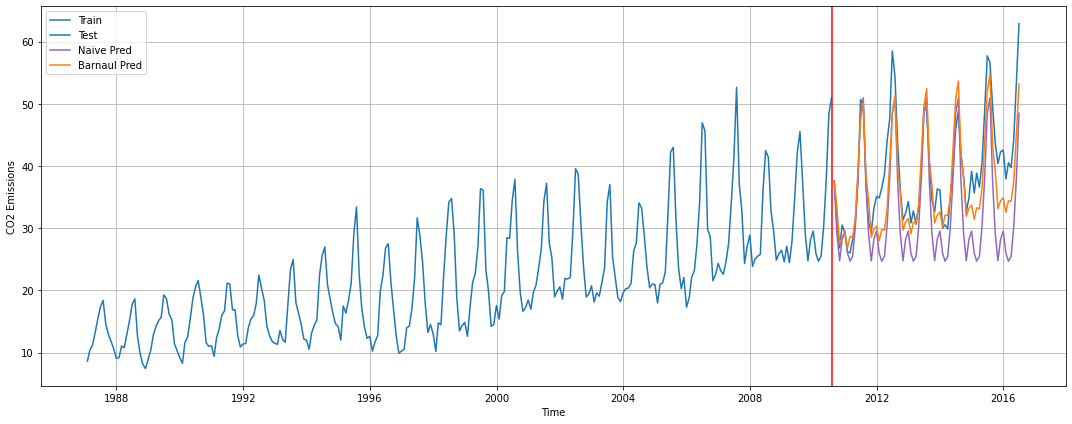

Barnaul MAE: 3.450245319638535
Naive MAE: 6.736661971830985


In [49]:
plt.figure(figsize=(15, 6))
plt.plot(train_df_ts1.index, train_df_ts1, label='Train', color='#1f77b4')
plt.plot(test_df_ts1.index, test_df_ts1, label='Test', color='#1f77b4')
plt.plot(test_df_ts1.index, y_pred, label='Naive Pred', color='#9467bd')
plt.plot(test_df_ts1.index, predictions, label='Barnaul Pred', color='#ff7f0e')
plt.axvline(x=train_df_ts1.index[-1], color='red')
plt.xlabel('Time')
plt.ylabel('CO2 Emissions')
plt.grid(b=1)
plt.tight_layout()
plt.legend()
plt.show()  
print('Barnaul MAE:', mean_absolute_error(test_df_ts1, predictions))
print('Naive MAE:', mean_absolute_error(test_df_ts1, y_pred))